In [49]:
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np

from astropy import units as u
import ccdproc as ccdp

from convenience_functions import show_image
from astropy.io import fits

filter = 'Luminance'
plt.style.use('guide.mplstyle')

In [50]:
raw_path = '../2022_03_20/RV_UMa/Light/Luminance'
dark_path = '../darks-reduced'
bias_path = '../bias-reduced/combined_bias.fit'
flats_path = Path('..', 'reduced-flats', filter)

In [51]:
science_raw = ccdp.ImageFileCollection(raw_path)
master_darks = ccdp.ImageFileCollection(dark_path)
master_flats = ccdp.ImageFileCollection(flats_path)


science_image_type = 'Light Frame'

combined_darks = {ccd.header['exptime']: ccd for ccd in master_darks.ccds(imagetyp='Dark Frame', combined=True)}
combined_flats = {ccd.header['filter']: ccd for ccd in master_flats.ccds(imagetyp='Flat Frame', combined=True)}


In [52]:
caca = '../2022_03_20/RV_UMa/Light/Luminance/' + 'RV_Uma_Light_Luminance_16_secs_001.fits'
raw_image = fits.open(caca)[0].data

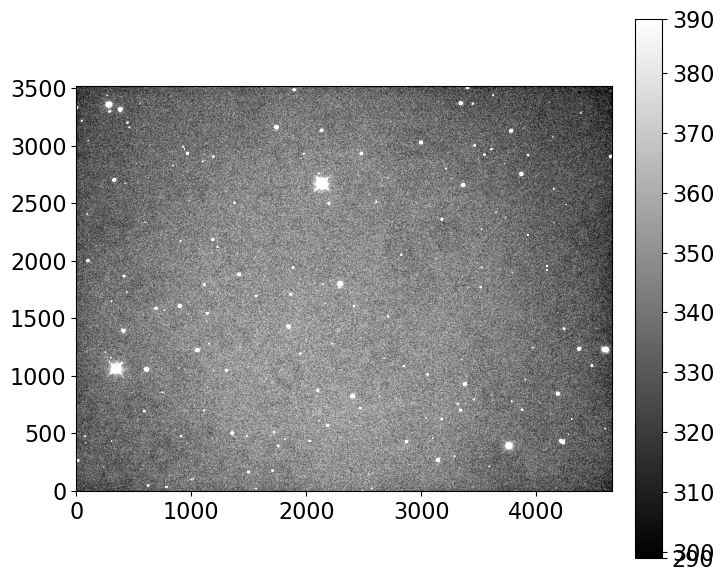

In [53]:
show_image(raw_image, cmap = 'gray')
plt.savefig('./Images/Raw_image.png')

In [54]:
def find_nearest_dark_exposure(image, dark_exposure_times, tolerance=0.5):
    """
    Find the nearest exposure time of a dark frame to the exposure time of the image,
    raising an error if the difference in exposure time is more than tolerance.

    Parameters
    ----------

    image : astropy.nddata.CCDData
        Image for which a matching dark is needed.

    dark_exposure_times : list
        Exposure times for which there are darks.

    tolerance : float or ``None``, optional
        Maximum difference, in seconds, between the image and the closest dark. Set
        to ``None`` to skip the tolerance test.

    Returns
    -------

    float
        Closest dark exposure time to the image.
    """

    dark_exposures = np.array(list(dark_exposure_times))
    idx = np.argmin(np.abs(dark_exposures - image.header['exptime']))
    closest_dark_exposure = dark_exposures[idx]

    if (tolerance is not None and
            np.abs(image.header['exptime'] - closest_dark_exposure) > tolerance):

        raise RuntimeError('Closest dark exposure time is {} for flat of exposure '
                           'time {}.'.format(closest_dark_exposure, image.header['exptime']))


    return closest_dark_exposure

In [55]:
for light, file_name in science_raw.ccds(imagetyp=science_image_type, return_fname=True, ccd_kwargs=dict(unit='adu')):
    closest_dark = find_nearest_dark_exposure(light, combined_darks.keys())
    print(closest_dark)
    reduced_dark = ccdp.subtract_dark(light, combined_darks[closest_dark],
                                 exposure_time='exptime', exposure_unit=u.second
                                 )
    break

16.0


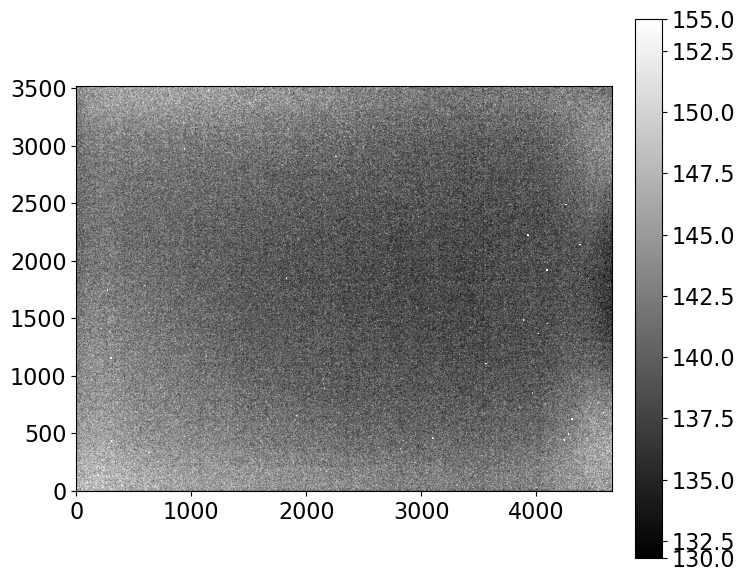

In [56]:
show_image(combined_darks[closest_dark], cmap = 'gray')
plt.savefig('./Images/good_dark.png')

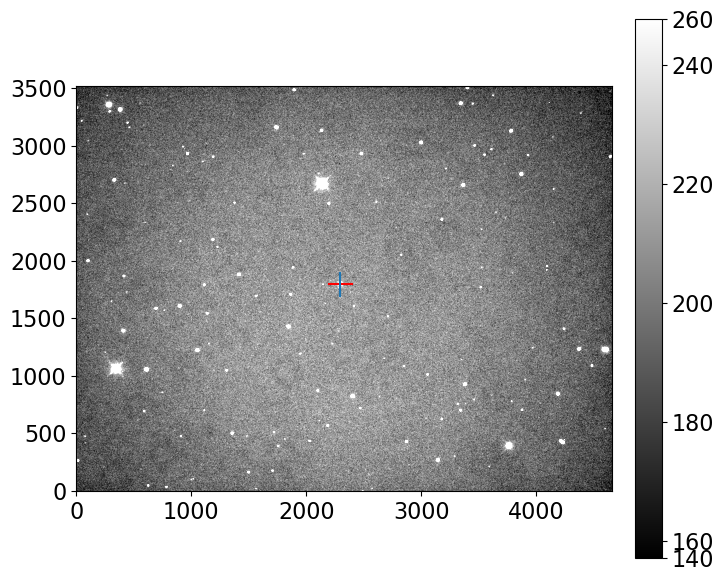

In [57]:
show_image(reduced_dark, cmap = 'gray')
plt.savefig('./Images/subtracted_dark.png')
x = 2295.417797
y = 1798.578271

plt.plot([x - 100, x+100], [y, y], 'r-')
plt.plot([x,x], [y-100, y + 100])

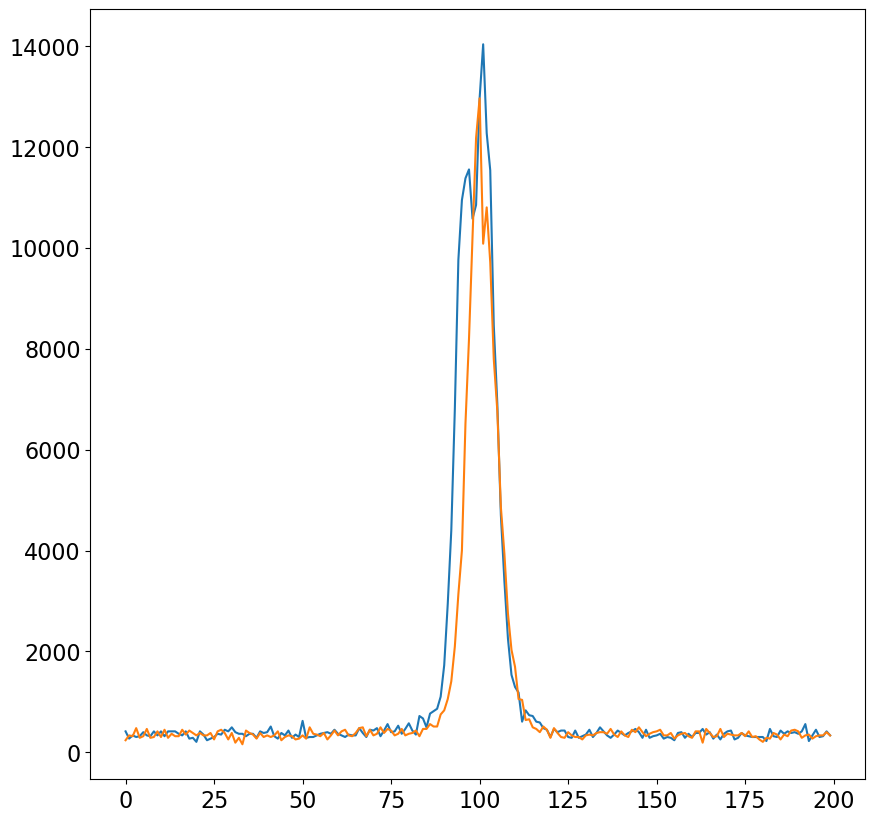

In [58]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(raw_image[np.floor(y).astype(int)][np.floor(x).astype(int) - 100 : np.floor(x).astype(int)+100])
plt.plot(raw_image.T[np.floor(x).astype(int)][np.floor(y).astype(int) - 100 : np.floor(y).astype(int)+100])
plt.savefig('./Images/line_profile_raw.png')

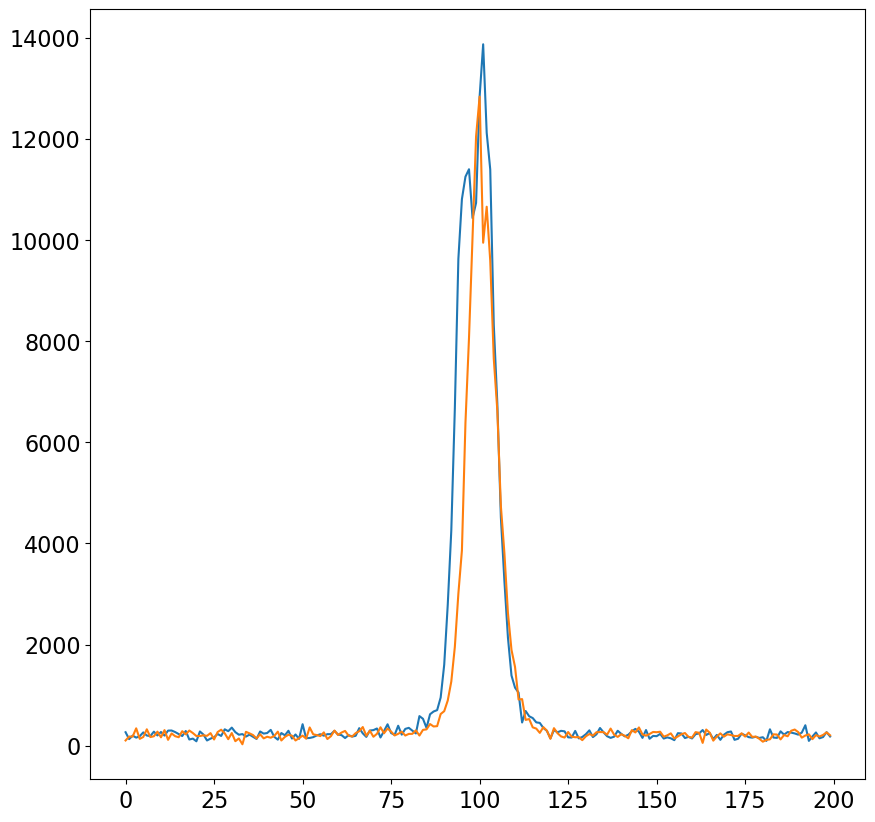

In [59]:


plt.plot(reduced_dark.data[np.floor(y).astype(int)][np.floor(x).astype(int) - 100 : np.floor(x).astype(int)+100])
plt.plot(reduced_dark.data.T[np.floor(x).astype(int)][np.floor(y).astype(int) - 100 : np.floor(y).astype(int)+100])
plt.savefig('./Images/reduced_dark_line_profile.png')

In [60]:
good_flat = combined_flats[reduced_dark.header['filter']]
reduced = ccdp.flat_correct(reduced_dark, good_flat)

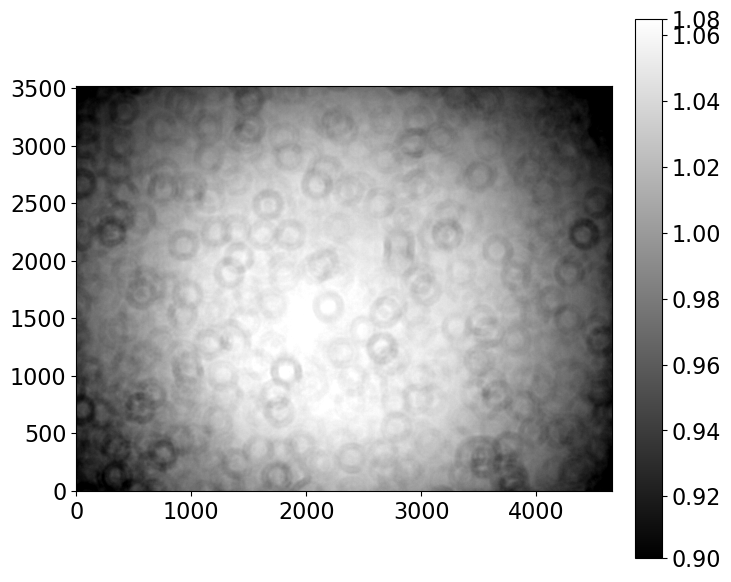

In [61]:
show_image(good_flat, cmap = 'gray')
plt.savefig('./Images/good_flat.png')

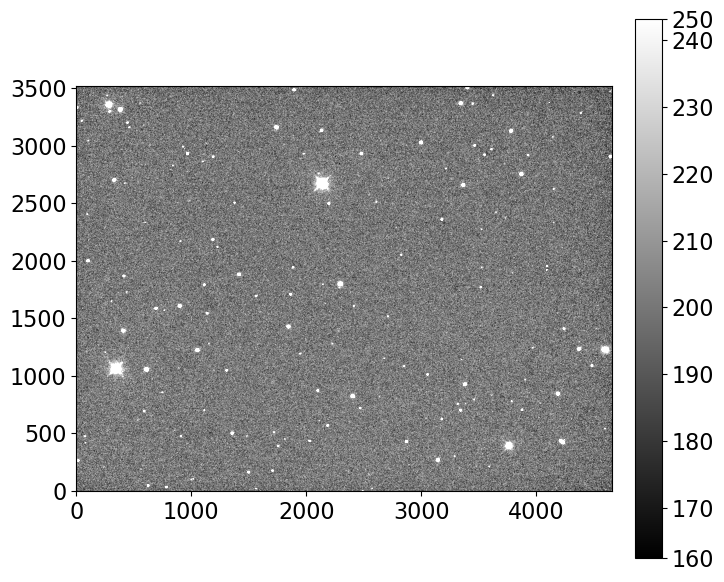

In [62]:
show_image(reduced, cmap = 'gray')
plt.savefig('./Images/fully_reduced.png')

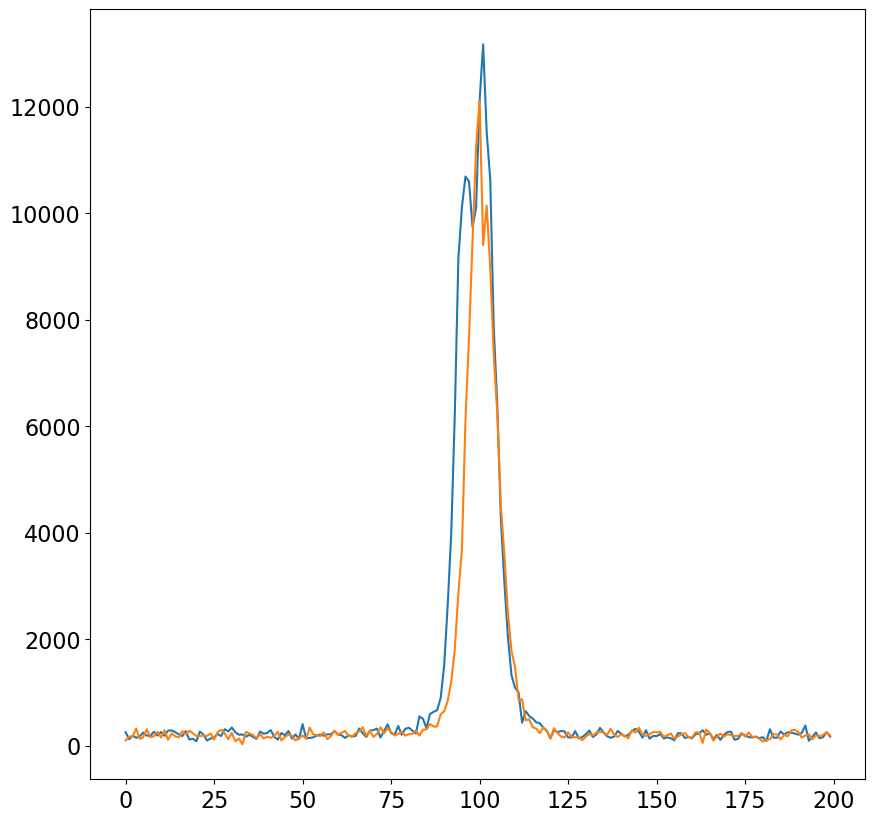

In [63]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np

plt.plot(reduced.data[np.floor(y).astype(int)][np.floor(x).astype(int) - 100 : np.floor(x).astype(int)+100])
plt.plot(reduced.data.T[np.floor(x).astype(int)][np.floor(y).astype(int) - 100 : np.floor(y).astype(int)+100])
plt.savefig('./Images/fully_reduced_line_profile.png')